In [151]:
# імпортуємо бібліотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from neuralprophet import NeuralProphet
%matplotlib inline

In [152]:
# завантажуємо датасет
df = pd.read_csv('weather.csv')
df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Kryvyi Rih,2020-09-01,35.0,17.0,26.7,32.6,17.0,25.7,6.0,29.7,...,22.9,8,NaN,2020-09-01T06:04:50,2020-09-01T19:26:58,0.47,Clear,Clear conditions throughout the day.,clear-day,"UKDR,33791099999,33000399999"
1,Kryvyi Rih,2020-09-02,35.9,18.0,27.0,33.8,18.0,26.1,7.3,30.3,...,21.4,8,NaN,2020-09-02T06:06:11,2020-09-02T19:24:58,0.50,Clear,Clear conditions throughout the day.,clear-day,"UKDR,33791099999,33000399999"
2,Kryvyi Rih,2020-09-03,36.0,18.0,27.8,33.9,18.0,27.0,9.7,34.7,...,18.7,7,NaN,2020-09-03T06:07:32,2020-09-03T19:22:58,0.54,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"UKDR,33791099999,33000399999"
3,Kryvyi Rih,2020-09-04,29.0,19.0,24.3,28.5,19.0,24.2,14.2,55.0,...,7.0,3,NaN,2020-09-04T06:08:54,2020-09-04T19:20:57,0.57,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"UKDR,33791099999,33000399999"
4,Kryvyi Rih,2020-09-05,26.0,15.0,19.9,26.0,15.0,19.9,10.8,57.8,...,8.6,4,NaN,2020-09-05T06:10:15,2020-09-05T19:18:56,0.60,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"UKDR,33791099999,33000399999"


In [153]:
# удаляємо зайві стовпчики
df = df.loc[:, ['datetime', 'temp']]

# встановимо дату як індекс
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)
df.head()

,temp
datetime,
2020-09-01,26.7
2020-09-02,27.0
2020-09-03,27.8
2020-09-04,24.3
2020-09-05,19.9


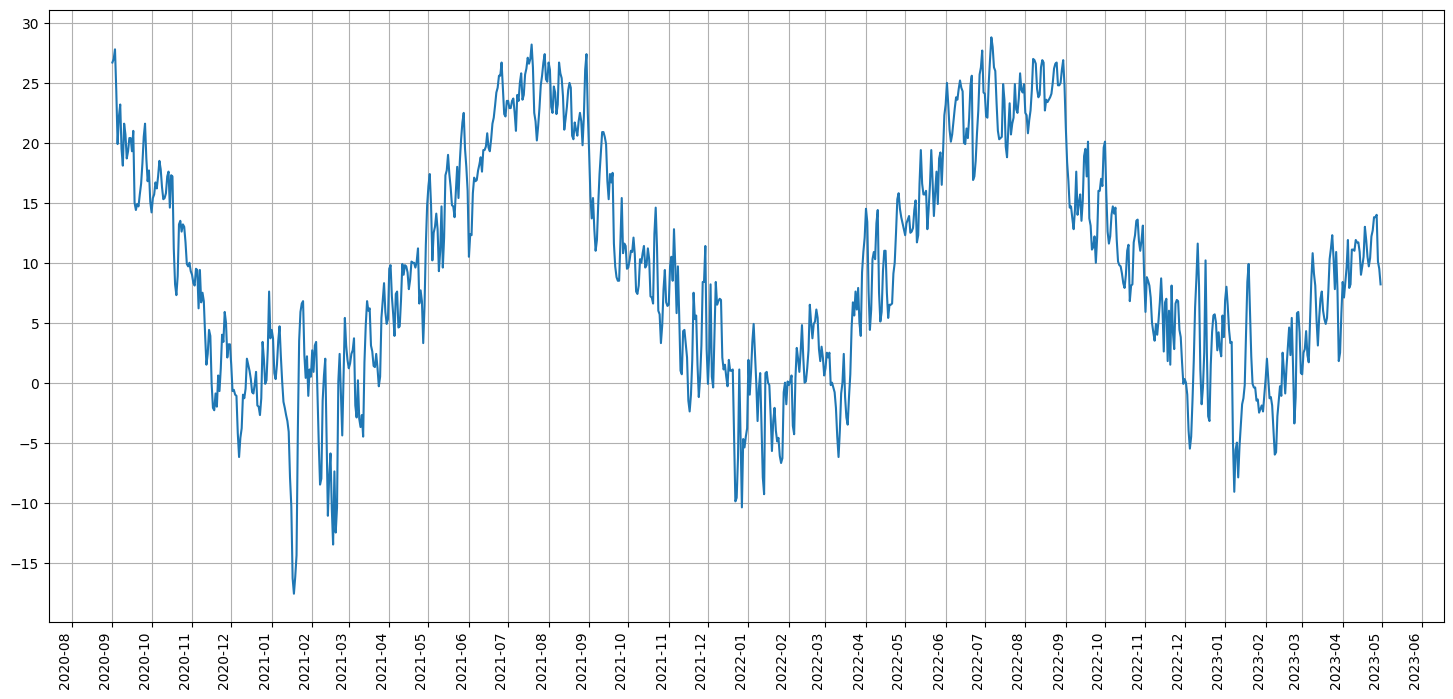

In [154]:
# створимо графік
fig, ax = plt.subplots(figsize=(18,9))
ax.plot(df.index, df['temp'])

# встановимо частоту місячних міток
month_loc = mdates.MonthLocator(bymonthday=1)
ax.xaxis.set_major_locator(month_loc)

# встановимо частоту місячних міток
month_loc = mdates.MonthLocator(bymonthday=1)
ax.xaxis.set_major_locator(month_loc)

# повернемо текст міток на 90 градусів
fig.autofmt_xdate(rotation=90)

# встановимо мітки на осі y через 5 градусів
y_loc = mticker.MultipleLocator(5)
ax.yaxis.set_major_locator(y_loc)

# додамо сітку
ax.grid(True)

# відобразимо графік
plt.show()


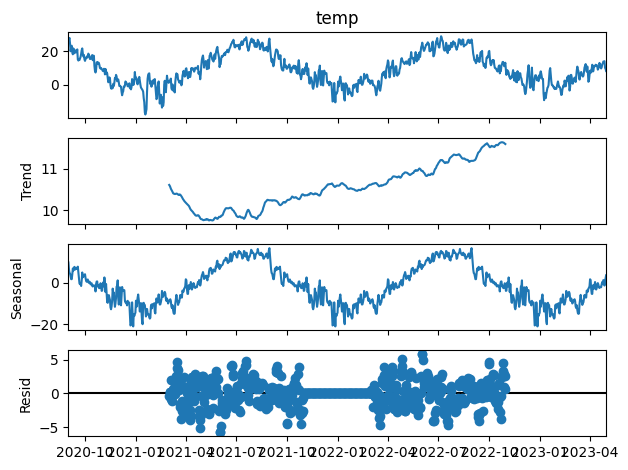

In [155]:
#Розкладемо ряд на компоненти
a = seasonal_decompose(df["temp"], model = "add", period=365)
a.plot();

In [156]:
#Поділимо датасет на тренувальний та тестовий
test_start = pd.Timestamp('2023-04-01')
test_end = pd.Timestamp('2023-04-30')

#В тренувальний датасет входять дані до першого квітня 2023 року
train_df = df.loc[df.index < test_start]

#В тестовий - квітень 2023 року
test_df = df.loc[(df.index >= test_start) & (df.index <= test_end)]


In [157]:
# Для використання з Prophet перейменуємо стовпці в ds та y відповідно
train_df_prophet = train_df.reset_index(drop=False)
train_df_prophet.columns = ['ds','y']

test_df_prophet = test_df.reset_index(drop=False)
test_df_prophet.columns = ['ds','y']


In [158]:
#інтервал надійності  95 % за замовчуванням дорівнює 80%
prophet = Prophet(interval_width=0.95, seasonality_mode='additive') 

# Додаємо сезонність на рівні року
prophet.add_seasonality(name='yearly', period=365.25, fourier_order=10)

model = prophet.fit(train_df_prophet, ) #навчання моделі
future = prophet.make_future_dataframe(periods=30) 

18:03:17 - cmdstanpy - INFO - Chain [1] start processing
18:03:17 - cmdstanpy - INFO - Chain [1] done processing


In [159]:
forecast = prophet.predict(future)

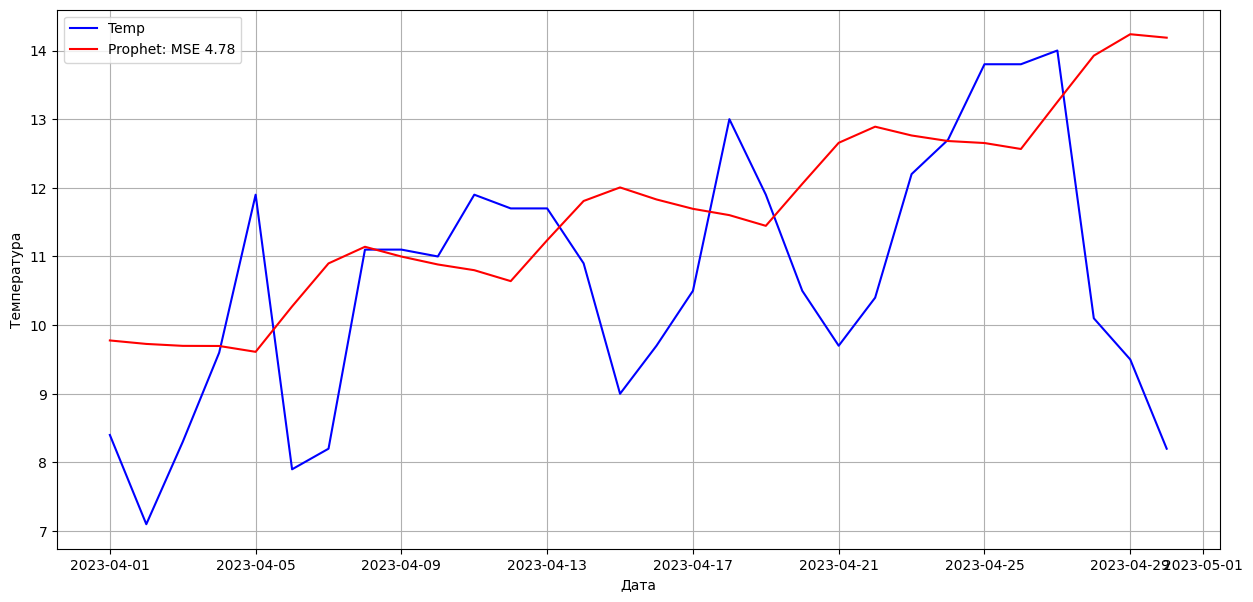

In [160]:
# Побудова графіку
results = forecast.copy()
results = results.loc[:, ['ds', 'yhat']]
results = results.tail(30).reset_index(drop=True)
results = pd.merge(results, test_df_prophet, on='ds', how='left')

# Обрати прогнозні значення та реальні значення
y_pred = results['yhat']
y_true = results['y']

# Обчислити MSE
mse_prophet = mean_squared_error(y_true, y_pred)


# Побудова графіку
fig, ax = plt.subplots(figsize=(15, 7))

# Графік температури з дадасету
ax.plot(results['ds'], results['y'], label='Temp', color='blue')

# Графік передбачення Prophet
ax.plot(results['ds'], results['yhat'], label='Prophet: MSE {:.2f}'.format(mse_prophet), color='red')

# Налаштування легенди та осей
ax.set_xlabel('Дата')
ax.set_ylabel('Температура')
ax.legend(loc='upper left')

# додамо сітку
ax.grid(True)

# відобразимо графік
plt.show()

In [161]:
# Перетворення індексу на стовпець 'ds', а значення - на стовпець 'y'
# Для використання з NeuralProphet перейменуємо стовпці в ds та y відповідно
train_df_nprophet = train_df.reset_index(drop=False)
train_df_nprophet.columns = ['ds','y']

test_df_nprophet = test_df.reset_index(drop=False)
test_df_nprophet.columns = ['ds','y']


In [162]:
# Визначення конфігурації моделі NeuralProphet
model = NeuralProphet(
    seasonality_mode='additive',   # Режим сезонності. "additive" для адитивної сезонності, 
                                         # "multiplicative" для мультиплікативної сезонності.
    seasonality_reg=0.1,     # Коефіцієнт регуляризації для сезонності
    learning_rate=0.01,      # Швидкість навчання
    epochs=1000,              # Кількість епох навчання
    batch_size=32,           # Розмір пакета для стохастичного градієнтного спуску
    loss_func='Huber',       # Функція втрат
    yearly_seasonality=True, # Включення річної сезонності 
)



INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.


In [163]:
# Навчання моделі та отримання прогнозів
metrics = model.fit(train_df_nprophet)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.894% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


Training: 0it [00:00, ?it/s]

In [164]:
future = model.make_future_dataframe(train_df_nprophet, periods=30)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.894% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [165]:
forecast = model.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 30it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [166]:
# Побудова графіку
results_np = forecast.copy()
results_np = results_np.loc[:, ['ds', 'yhat1']]
results_np = pd.merge(results_np, test_df_prophet, on='ds', how='left')

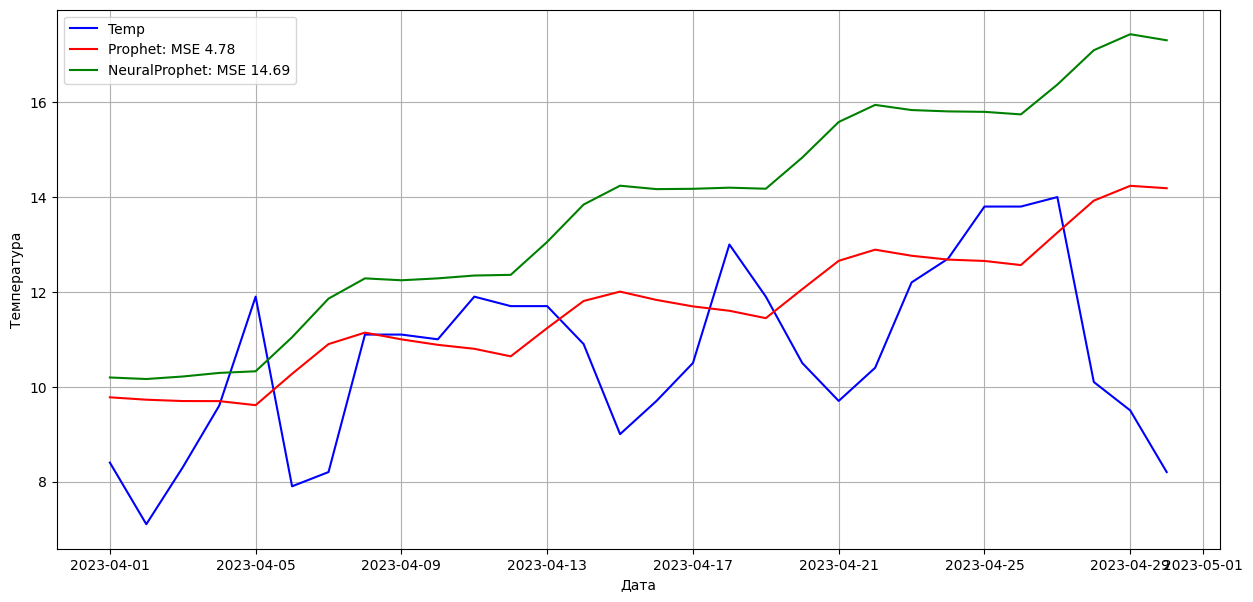

In [167]:
# Побудова графіку
results_np = forecast.copy()
results_np = results_np.loc[:, ['ds', 'yhat1']]
results_np = pd.merge(results_np, test_df_prophet, on='ds', how='left')

# Обрати прогнозні значення та реальні значення
y_pred_np = results_np['yhat1']
y_true_np = results_np['y']

# Обчислити MSE
mse_neural_prophet = mean_squared_error(y_true_np, y_pred_np)


# Побудова графіку
fig, ax = plt.subplots(figsize=(15, 7))

# Графік температури з дадасету
ax.plot(results['ds'], results['y'], label='Temp', color='blue')

# Графік передбачення Prophet
ax.plot(results['ds'], results['yhat'], label='Prophet: MSE {:.2f}'.format(mse_prophet), color='red')

# Графік передбачення NeuralProphet
ax.plot(results['ds'], results_np['yhat1'], label='NeuralProphet: MSE {:.2f}'.format(mse_neural_prophet), color='green')

# Налаштування легенди та осей
ax.set_xlabel('Дата')
ax.set_ylabel('Температура')
ax.legend(loc='upper left')

# додамо сітку
ax.grid(True)

# відобразимо графік
plt.show()

In [168]:
#Підготовка даних для LTSM моделі
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Нормалізація даних
data = df['temp'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Розділення даних на навчальний та тестовий набори
train_size = int(len(scaled_data) - 40)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [169]:
# Функція для створення даних зі зсувом для LSTM
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)


In [170]:
# Параметри моделі та тренування
window_size = 10
train_X, train_y = create_dataset(train_data, window_size)
test_X, test_y = create_dataset(test_data, window_size)

# Побудова та навчання моделі LSTM
model = Sequential()
model.add(LSTM(300, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X, train_y, epochs=30, batch_size=16)

# Прогнозування температури для тестового набору
predictions = model.predict(test_X)

# Відновлення оригінальних значень температури
predictions = scaler.inverse_transform(predictions)


Epoch 1/30


2023-05-18 21:47:47.939769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-18 21:47:47.942087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-18 21:47:47.943645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

58/58 [==============================] - 4s 25ms/step - loss: 0.0257
Epoch 2/30
58/58 [==============================] - 4s 69ms/step - loss: 0.0067
Epoch 3/30
58/58 [==============================] - 4s 66ms/step - loss: 0.0064
Epoch 4/30
58/58 [==============================] - 4s 62ms/step - loss: 0.0060
Epoch 5/30
58/58 [==============================] - 3s 61ms/step - loss: 0.0063
Epoch 6/30
58/58 [==============================] - 2s 31ms/step - loss: 0.0055
Epoch 7/30
58/58 [==============================] - 4s 62ms/step - loss: 0.0057
Epoch 8/30
58/58 [==============================] - 4s 61ms/step - loss: 0.0054
Epoch 9/30
58/58 [==============================] - 4s 68ms/step - loss: 0.0050
Epoch 10/30
58/58 [==============================] - 2s 40ms/step - loss: 0.0048
Epoch 11/30
58/58 [==============================] - 2s 39ms/step - loss: 0.0049
Epoch 12/30
58/58 [==============================] - 2s 35ms/step - loss: 0.0046
Epoch 13/30
58/58 [=============================

2023-05-18 21:49:12.545005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-18 21:49:12.549326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-18 21:49:12.552416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 761ms/step


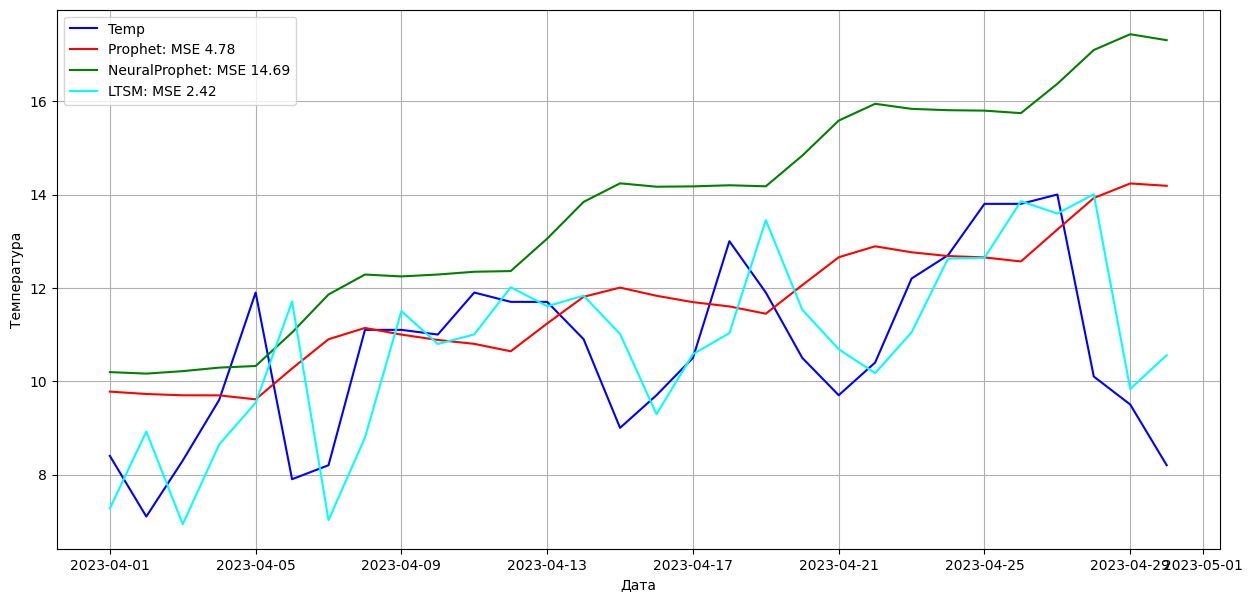

In [171]:
# Побудова графіку
results_np = forecast.copy()
results_np = results_np.loc[:, ['ds', 'yhat1']]
results_np = pd.merge(results_np, test_df_prophet, on='ds', how='left')

results_LTSM = pd.DataFrame(predictions, columns=['y_LTSM'])

# Обрати прогнозні значення та реальні значення
y_pred_np = results_LTSM['y_LTSM']
y_true_np = results_np['y']

# Обчислити MSE
mse_LTSM = mean_squared_error(y_true_np, y_pred_np)


# Побудова графіку
fig, ax = plt.subplots(figsize=(15, 7))

# Графік температури з дадасету
ax.plot(results['ds'], results['y'], label='Temp', color='blue')

# Графік передбачення Prophet
ax.plot(results['ds'], results['yhat'], label='Prophet: MSE {:.2f}'.format(mse_prophet), color='red')

# Графік передбачення NeuralProphet
ax.plot(results['ds'], results_np['yhat1'], label='NeuralProphet: MSE {:.2f}'.format(mse_neural_prophet), color='green')

# Графік передбачення LTSM
ax.plot(results['ds'], results_LTSM['y_LTSM'], label='LTSM: MSE {:.2f}'.format(mse_LTSM), color='cyan')


# Налаштування легенди та осей
ax.set_xlabel('Дата')
ax.set_ylabel('Температура')
ax.legend(loc='upper left')

# додамо сітку
ax.grid(True)

# відобразимо графік
plt.show()